In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()


In [2]:
IMAGE_SIZE = [176,208]              
BATCH_SIZE = 5000
test_split_percent = .1       
validation_split_percent = .2 
zoom = [.99,1.01]             
bright_range = [.8,1.2]       
layers_unlocked = True        
lr = 0.01                   
batch = 20                    
EPOCHS = 20     

In [3]:
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="./archive/Training/",target_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE)

test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 
test_data_gen = test_dr.flow_from_directory(directory="./archive/Testing",target_size=IMAGE_SIZE,batch_size=BATCH_SIZE,
                                           shuffle = False) 

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [4]:
train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

In [5]:
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6311, 176, 208, 3)
(6311, 4)


In [6]:
initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4417, 176, 208, 3)
validation (632, 176, 208, 3)
test (1262, 176, 208, 3)


In [7]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4417, 176, 208, 3)
(4417, 4)
(632, 176, 208, 3)
(632, 4)
(1262, 176, 208, 3)
(1262, 4)


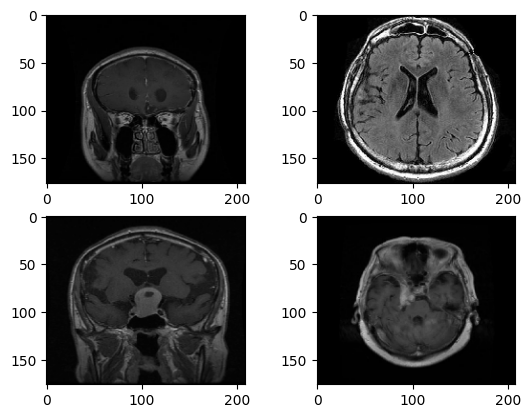

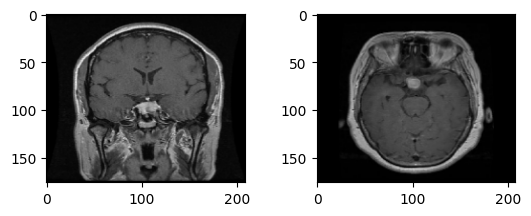

In [8]:
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [9]:
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


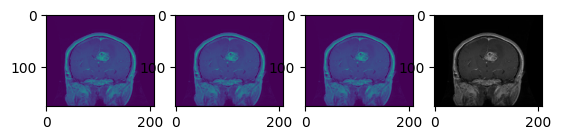

In [10]:
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

In [11]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [12]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [13]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model

In [14]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc')]

    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [15]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

## CNN Model Training

In [17]:
cnn_model_history = model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                             epochs=EPOCHS,batch_size=batch, shuffle=True) 

Epoch 1/20

221/221 [==============================] - 81s 343ms/step - loss: 1.2071 - accuracy: 0.7842 - precision: 0.5883 - recall: 0.4564 - auc: 0.7847 - val_loss: 1.4847 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5066
Epoch 2/20
221/221 [==============================] - 74s 337ms/step - loss: 0.7622 - accuracy: 0.8514 - precision: 0.7346 - recall: 0.6348 - auc: 0.9017 - val_loss: 1.7349 - val_accuracy: 0.6377 - val_precision: 0.2753 - val_recall: 0.2753 - val_auc: 0.5950
Epoch 3/20
221/221 [==============================] - 77s 348ms/step - loss: 0.6385 - accuracy: 0.8767 - precision: 0.7813 - recall: 0.7036 - auc: 0.9296 - val_loss: 1.0673 - val_accuracy: 0.7706 - val_precision: 0.5765 - val_recall: 0.3101 - val_auc: 0.7945
Epoch 4/20
221/221 [==============================] - 79s 355ms/step - loss: 0.5770 - accuracy: 0.8891 - precision: 0.8030 - recall: 0.7374 - auc: 0.9420 - val_loss: 0.7799 - val_accuracy: 0.8457 - val_precision: 0

In [18]:
pred_labels = model.predict(test_data)

40/40 [==============================] - 6s 132ms/step


In [19]:
pred_labels

array([[8.9786525e-05, 7.0249283e-04, 1.2946500e-05, 9.9919480e-01],
       [1.7894488e-03, 9.9782419e-01, 7.0520939e-05, 3.1582397e-04],
       [1.3392799e-05, 1.4803839e-03, 9.9846894e-01, 3.7158712e-05],
       ...,
       [8.1576931e-05, 6.3283644e-03, 9.9293375e-01, 6.5631478e-04],
       [9.9857974e-01, 7.3068106e-04, 6.7699346e-04, 1.2582033e-05],
       [4.7536207e-05, 4.2533793e-04, 1.3437048e-06, 9.9952579e-01]],
      dtype=float32)

In [20]:
cnn_accuracy = model.evaluate(test_data, test_labels)
print(f'CNN accuracy: {cnn_accuracy[1]*100}%')

40/40 [==============================] - 5s 133ms/step - loss: 0.1995 - accuracy: 0.9719 - precision: 0.9459 - recall: 0.9414 - auc: 0.9890
CNN accuracy: 97.18700647354126%


In [21]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 208, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 208, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 104, 16)       0         
 D)                                                              
                                                                 
 sequential (Sequential)     (None, 44, 52, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 22, 26, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 11, 13, 128)       27072     
                                                      

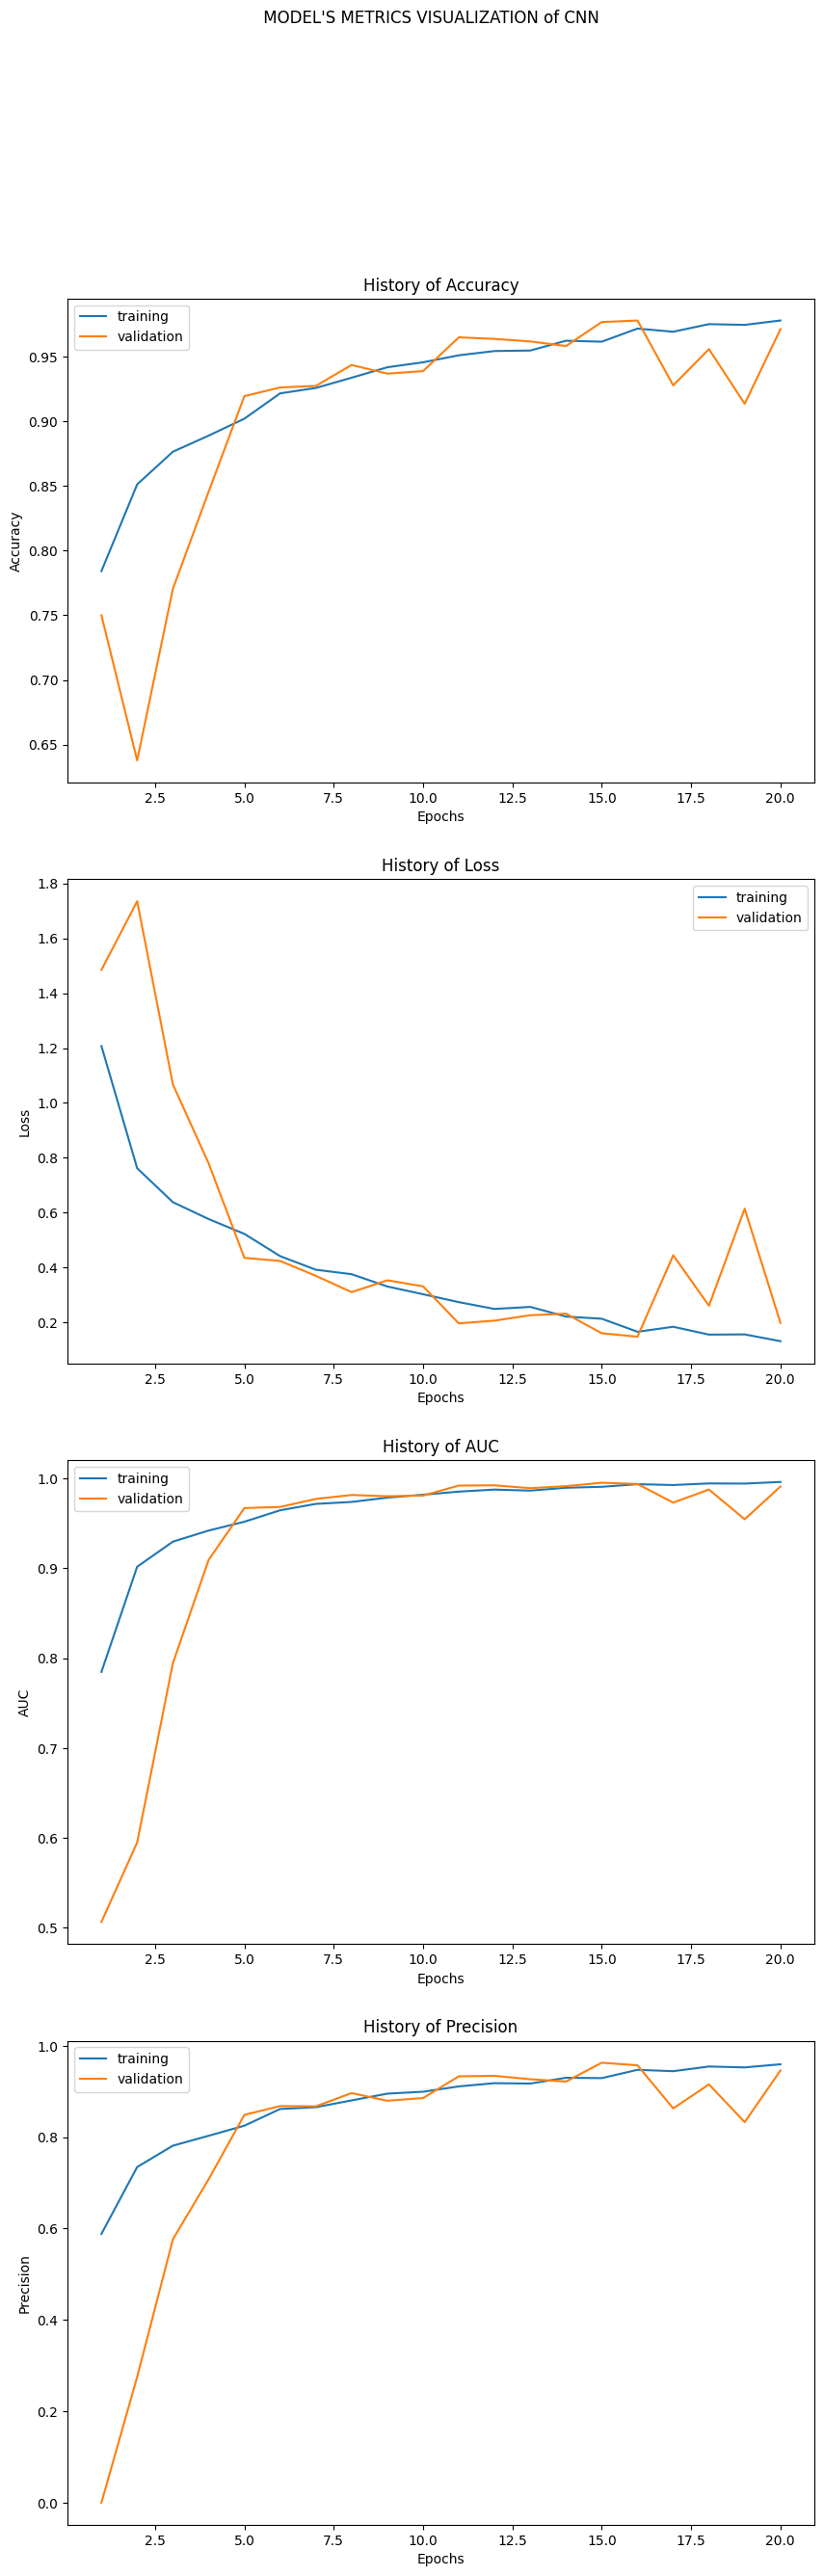

In [22]:
def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,30))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION of CNN")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    plt.show()
Train_Val_Plot(cnn_model_history.history['accuracy'],cnn_model_history.history['val_accuracy'],
               cnn_model_history.history['loss'],cnn_model_history.history['val_loss'],
               cnn_model_history.history['auc'],cnn_model_history.history['val_auc'],
              cnn_model_history.history['precision'],cnn_model_history.history['val_precision'])

In [24]:
CLASSES = ['Pituitary','Notumor','Meningioma','Glioma']
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

              precision    recall  f1-score   support

   Pituitary       0.97      0.88      0.93       287
     Notumor       0.83      0.98      0.90       283
  Meningioma       0.98      0.98      0.98       367
      Glioma       1.00      0.92      0.96       325

   micro avg       0.94      0.94      0.94      1262
   macro avg       0.95      0.94      0.94      1262
weighted avg       0.95      0.94      0.94      1262
 samples avg       0.94      0.94      0.94      1262



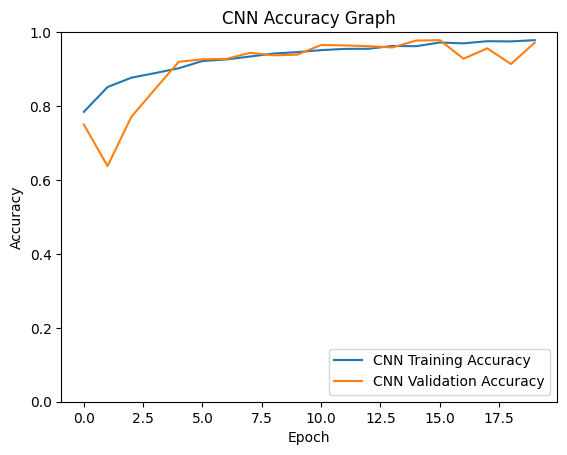

In [25]:
plt.plot(cnn_model_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_model_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.xlabel('Epoch')
plt.title("CNN Accuracy Graph")
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

## RNN

In [26]:
train_data_seq = train_data.reshape(train_data.shape[0], train_data.shape[1], -1)
test_data_seq = test_data.reshape(test_data.shape[0], test_data.shape[1], -1)

print(f"New Train Data Shape for RNN: {train_data_seq.shape}")  
print(f"New Test Data Shape for RNN: {test_data_seq.shape}")

New Train Data Shape for RNN: (4417, 176, 624)
New Test Data Shape for RNN: (1262, 176, 624)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='relu', input_shape=input_shape, return_sequences=True),
        SimpleRNN(20, activation='relu'),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
    ])
    
    return model

input_shape = (train_data_seq.shape[1], train_data_seq.shape[2])  

model = build_rnn_model(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 176, 50)           33750     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                1420      
                                                                 
 dense_4 (Dense)             (None, 64)                1344      
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 36774 (143.65 KB)
Trainable params: 36774 (143.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
rnn_history = model.fit(train_data_seq, train_labels, epochs=35, 
                        validation_data=(test_data_seq, test_labels), 
                        batch_size=32)
loss, accuracy = model.evaluate(test_data_seq, test_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/35

139/139 [==============================] - 90s 620ms/step - loss: 1.1732 - accuracy: 0.5128 - val_loss: 0.9835 - val_accuracy: 0.6228
Epoch 2/35
139/139 [==============================] - 107s 774ms/step - loss: 0.9290 - accuracy: 0.6305 - val_loss: 0.9089 - val_accuracy: 0.6521
Epoch 3/35
139/139 [==============================] - 96s 691ms/step - loss: 0.8309 - accuracy: 0.6753 - val_loss: 0.8265 - val_accuracy: 0.6823
Epoch 4/35
139/139 [==============================] - 92s 661ms/step - loss: 0.7380 - accuracy: 0.7066 - val_loss: 0.9280 - val_accuracy: 0.6141
Epoch 5/35
139/139 [==============================] - 92s 665ms/step - loss: 0.7543 - accuracy: 0.6887 - val_loss: 0.7373 - val_accuracy: 0.7250
Epoch 6/35
139/139 [==============================] - 93s 666ms/step - loss: 0.6687 - accuracy: 0.7310 - val_loss: 0.7269 - val_accuracy: 0.7203
Epoch 7/35
139/139 [==============================] - 92s 663ms/step - loss: 0.6401 - accuracy: 0.7492 - val_loss: 0.6791 - val_

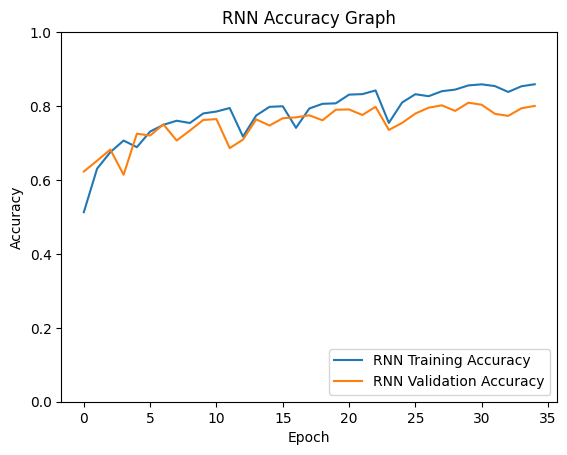

In [29]:
plt.plot(rnn_history.history['accuracy'], label='RNN Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("RNN Accuracy Graph")
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()